In [40]:
%load_ext autoreload
%autoreload 2

import parse_data.prepare_data as prepare_data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 300
import globals
import data_strings
import data_extraction.extract_trial as extract_trial
import utils.cosine_similarity as cosine_similarity
import analysis.wall_visibility_and_choice as wall_visibility_and_choice
import data_extraction.get_indices as get_indices
import plotting.plot_probability_chose_wall as plot_probability_chose_wall
import plotting.flipped_rotated_trajectory_testing_functions as fr_funcs
import analysis.opponent_visibility as opponent_visibility
from scipy.stats import wilcoxon
import plotting.plot_octagon as plot_octagon

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Notebook to identify opponent visibility at trial start 

In [41]:
## Load data files

In [42]:
data_folder = data_strings.DATA_FOLDER
json_filenames_all_social = data_strings.JSON_FILENAMES_SOCIAL
json_filenames_all_solo = data_strings.JSON_FILENAMES_SOLO

In [43]:
json_filenames = json_filenames_all_social[:-1]

In [ ]:
json_filenames

In [ ]:
df, trial_lists = prepare_data.prepare_data(data_folder, json_filenames, combine=False)

In [46]:
## calculate probabilities for specified conditions

In [58]:
# analysis variables
inferred_choice = True
current_fov = 110
chosen_wall_index=0
visible_wall_index=0
wall_sep = None
data_size_cutoff = 4

In [ ]:
(probabilities,
 trial_data) = opponent_visibility.probability_trial_outcome_given_conditions_all_sessions(trial_lists, inferred_choice, current_fov,
                                                            chosen_wall_index=chosen_wall_index, visible_wall_index=visible_wall_index,
                                                            trial_type=globals.HIGH_LOW, data_size_cutoff=data_size_cutoff,
                                                            debug=False)

wall_choice_probabilities = [probabilities['other_visible'].ravel(), probabilities['other_not_visible'].ravel()]

In [49]:
## Plot probabilities for this condition across visibility of Other

c:\users\tomha\repos\octagon_analysis\plotting\plot_probability_chose_wall.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Condition", y="Probability", data=df, palette=custom_palette, width=.8)
c:\users\tomha\repos\octagon_analysis\plotting\plot_probability_chose_wall.py:60: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.boxplot(x="Condition", y="Probability", data=df, palette=custom_palette, width=.8)


<Axes: ylabel='P(High | High initially visible)'>

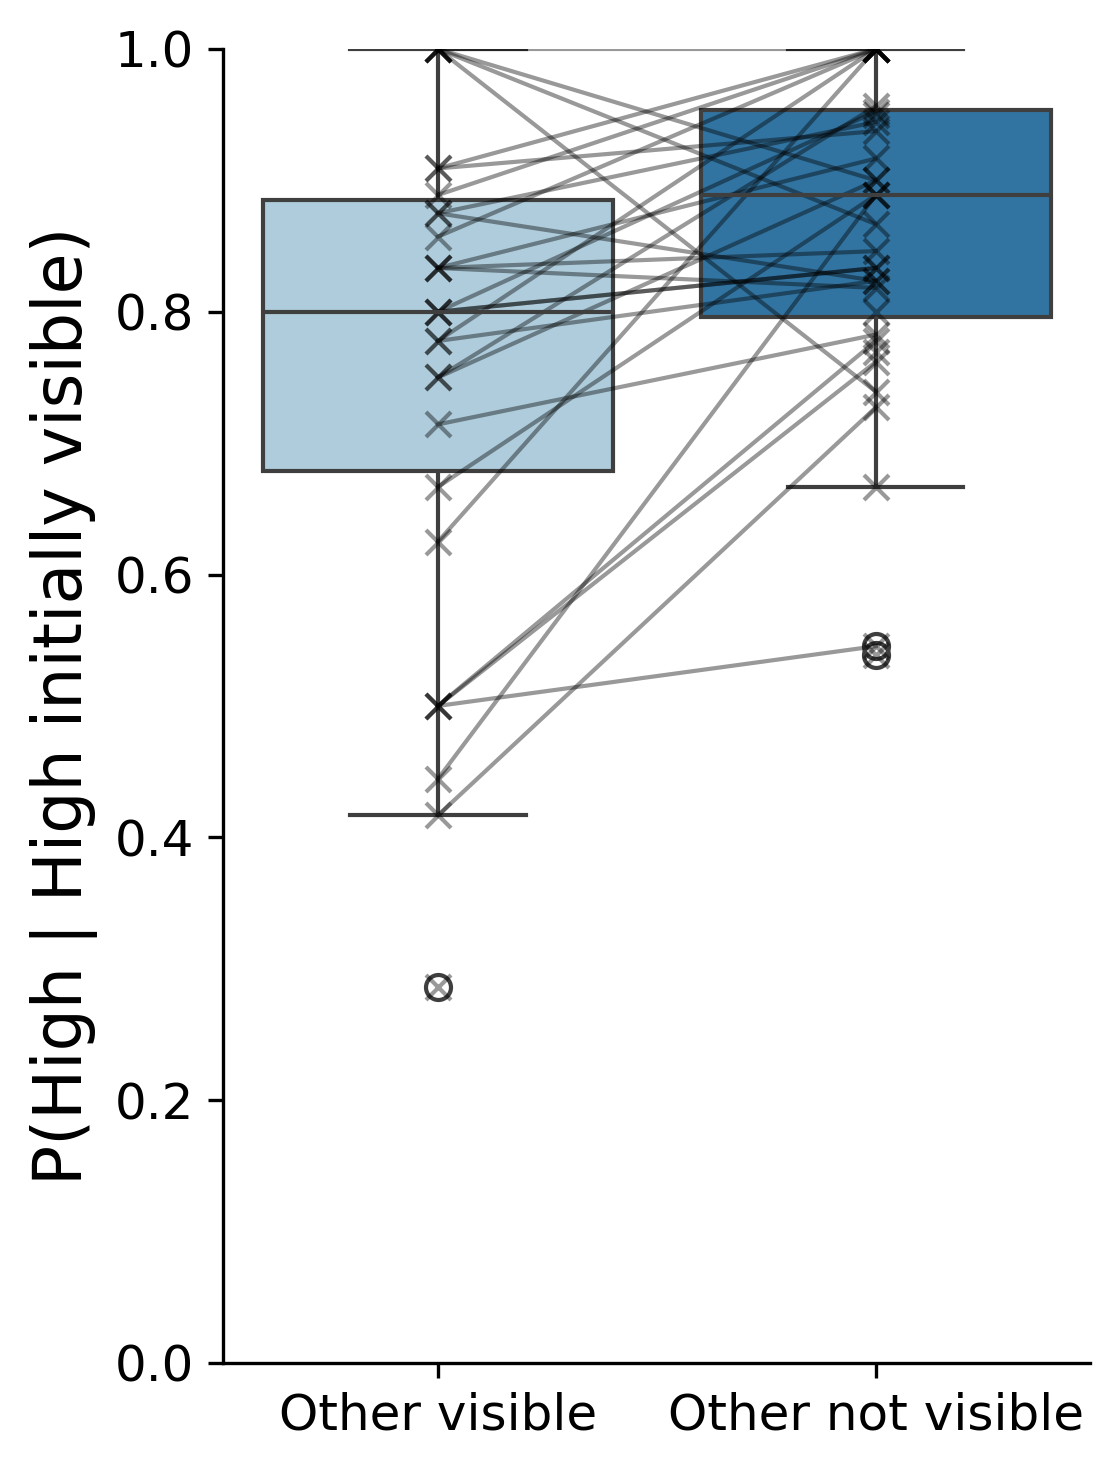

In [61]:
plot_probability_chose_wall.boxplot_probability_choose_wall(wall_choice_probabilities, ['Other visible', 'Other not visible'], ylabel="P(High | High initially visible)",
                                                            fontsize=16)

### Wilcoxon signed rank test

In [62]:
p_other_vis = probabilities['other_visible'].ravel()
p_other_non_vis = probabilities['other_not_visible'].ravel()


In [63]:
wilcoxon_nan_mask = ~np.isnan(p_other_vis) & ~np.isnan(p_other_non_vis)
p_other_vis_wilcoxon = p_other_vis[wilcoxon_nan_mask]
p_other_non_vis_wilcoxon = p_other_non_vis[wilcoxon_nan_mask]

In [64]:
p_other_non_vis_wilcoxon

array([0.83333333, 0.83333333, 0.81818182, 0.9       , 0.95652174,
       0.84615385, 0.91666667, 1.        , 0.88888889, 1.        ,
       0.73913043, 0.82352941, 0.7826087 , 0.76190476, 1.        ,
       1.        , 0.9375    , 0.77777778, 0.82352941, 1.        ,
       0.88888889, 0.86666667, 0.94444444, 0.9       , 1.        ,
       0.72727273, 0.54545455, 0.95238095])

In [65]:
# Perform Wilcoxon signed-rank test
stat, p_value = wilcoxon(p_other_vis_wilcoxon, p_other_non_vis_wilcoxon)

# Print results
print(f"Wilcoxon test statistic: {stat}")
print(f"P-value: {p_value}")

Wilcoxon test statistic: 60.0
P-value: 0.0019388127757589827


#### Plotting self and other trial start positions

In [16]:
len(trial_lists[6])

114

In [ ]:
# idx_other_vis_high_vis, idx_other_not_vis_high_vis

NameError: name 'idx_other_vis_high_vis' is not defined

In [82]:
# a = [trial_lists[session_id][i] for i in idx_other_vis_high_vis]

In [18]:
trials_other_vis_high_vis_p0_session = []
trials_other_vis_high_vis_p1_session = []

for session_id in range(len(trial_lists)):
    trial_list = trial_lists[session_id]

    # filter trial list for specified trial type (e.g., HIGH_LOW)
    # currently my function for returning original indices does not account for the fact it pre-filters by HIGH_LOW
    trial_indices = get_indices.get_trials_trialtype(trial_list, trial_type=globals.HIGH_LOW)
    trial_list_filtered = [trial_list[i] for i in trial_indices]

    # get indices for trials where p0 or p1 see the High wall and Other
    idx_other_vis_high_vis_p0 = trial_data['denominator_other_visible'][0][session_id] # all trials with high vis, other vis
    idx_other_vis_high_vis_p1 = trial_data['denominator_other_visible'][1][session_id] # all trials with high vis, other vis

    idx_other_not_vis_high_vis_p0 = trial_data['denominator_other_not_visible'][0][session_id] # all trials with high vis, other not vis


    # index the trial list with these indices
    trials_other_vis_high_vis_p0 = [trial_list_filtered[i] for i in idx_other_vis_high_vis_p0]
    trials_other_vis_high_vis_p1 = [trial_list_filtered[i] for i in idx_other_vis_high_vis_p1]

    trials_other_vis_high_vis_p0_session.append(trials_other_vis_high_vis_p0)
    trials_other_vis_high_vis_p1_session.append(trials_other_vis_high_vis_p1)


# then see below code for extracting trial start position of self and other, and plotting




<class 'matplotlib.axes._axes.Axes'>


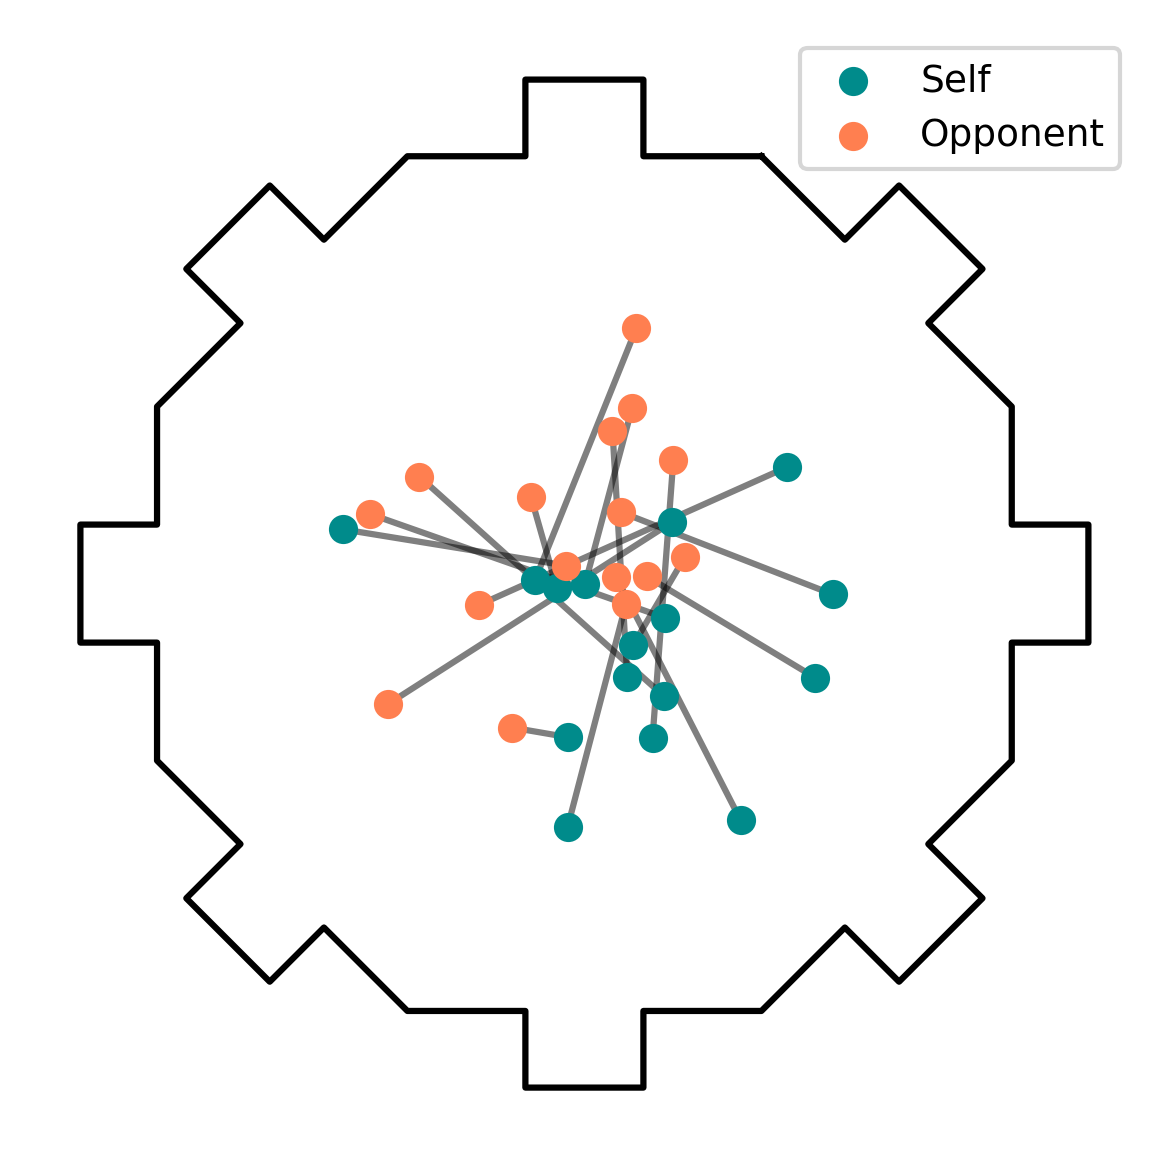

In [31]:
# plot trial start positions for self and other, combining both players in a session, 
# only for trials with Other visible and H visible at trial start
# TODO rewrite cleanly to avoid 
# TODO repeat for the list of trials where Other is NOT visible
# TODO see 250123 octagon meeting notes for how to polish these plots and best use them

# session_id = -4
# session_id = 4
# session_id = 10
# session_id = 11
# session_id = 14
session_id = 15


trials_other_vis_high_vis_p0 = trials_other_vis_high_vis_p0_session[session_id]
trials_other_vis_high_vis_p1 = trials_other_vis_high_vis_p1_session[session_id]

chosen_walls_session = np.zeros(len(trials_other_vis_high_vis_p0 + trials_other_vis_high_vis_p1))  # unused for this analysis

# # trial lists
# filtered_trail_list_a_list          # all trials with Other and High visible
# filtered_trial_list_choice_a_list   # all trials with Other not viisble and High visible

# trials_other_vis_high_vis_p0 = [trial_lists[session_id][i] for i in idx_other_vis_high_vis_p0]
# trials_other_vis_high_vis_p1 = [trial_lists[session_id][i] for i in idx_other_vis_high_vis_p1]

# starting with player 0, the first index 
player_id = 0

# Run the first trial out of the loop to generate the plotted octagon axes
trial = trials_other_vis_high_vis_p0[0]
(_, _, 
rotated_flipped_trial, _,
chosen_wall) = fr_funcs.get_trajectory_information_trial(chosen_walls_session, trial=trial)
ax = fr_funcs.plot_player_start_positions(rotated_flipped_trial, chosen_player=player_id, label=True, axes=None)
print(type(ax))

# now loop the rest of player_id 0 trials
for i, trial in enumerate(trials_other_vis_high_vis_p0[1:]):
    (_, _, 
    rotated_flipped_trial, _,
    chosen_wall) = fr_funcs.get_trajectory_information_trial(chosen_walls_session, trial=trial)
    ax = fr_funcs.plot_player_start_positions(rotated_flipped_trial, chosen_player=player_id, label=False, axes=ax)

# now loop all player_id 1 trials
player_id = 1
for i, trial in enumerate(trials_other_vis_high_vis_p1):
    (_, _, 
    rotated_flipped_trial, _,
    chosen_wall) = fr_funcs.get_trajectory_information_trial(chosen_walls_session, trial=trial)
    ax = fr_funcs.plot_player_start_positions(rotated_flipped_trial, chosen_player=player_id, label=False, axes=ax)


In [ ]:
# plot trial start positions for self and other, combining both players in a session, 
# only for trials with Other visible and H visible at trial start
# TODO rewrite cleanly to avoid 
# TODO repeat for the list of trials where Other is NOT visible
# TODO see 250123 octagon meeting notes for how to polish these plots and best use them

fig, axs = plt.subplots(10,2, figsize=(20,20))

for i in range(len(trial_lists)):

    trials_other_vis_high_vis_p0 = trials_other_vis_high_vis_p0_session[i]
    trials_other_vis_high_vis_p1 = trials_other_vis_high_vis_p1_session[i]

    ax = axs.flatten()[i]
    ax = plot_octagon.plot_octagon(ax)

    chosen_walls_session = np.zeros(len(trials_other_vis_high_vis_p0 + trials_other_vis_high_vis_p1))  # unused for this analysis

    # # trial lists
    # filtered_trail_list_a_list          # all trials with Other and High visible
    # filtered_trial_list_choice_a_list   # all trials with Other not viisble and High visible

    # trials_other_vis_high_vis_p0 = [trial_lists[session_id][i] for i in idx_other_vis_high_vis_p0]
    # trials_other_vis_high_vis_p1 = [trial_lists[session_id][i] for i in idx_other_vis_high_vis_p1]

    # starting with player 0, the first index 
    player_id = 0

    # Run the first trial out of the loop to generate the plotted octagon axes
    trial = trials_other_vis_high_vis_p0[0]
    (_, _, 
    rotated_flipped_trial, _,
    chosen_wall) = fr_funcs.get_trajectory_information_trial(chosen_walls_session, trial=trial)
    ax = fr_funcs.plot_player_start_positions(rotated_flipped_trial, chosen_player=player_id, label=True, axes=ax)
    print(type(ax))

    # now loop the rest of player_id 0 trials
    for i, trial in enumerate(trials_other_vis_high_vis_p0[1:]):
        (_, _, 
        rotated_flipped_trial, _,
        chosen_wall) = fr_funcs.get_trajectory_information_trial(chosen_walls_session, trial=trial)
        ax = fr_funcs.plot_player_start_positions(rotated_flipped_trial, chosen_player=player_id, label=False, axes=ax)

    # now loop all player_id 1 trials
    player_id = 1
    for i, trial in enumerate(trials_other_vis_high_vis_p1):
        (_, _, 
        rotated_flipped_trial, _,
        chosen_wall) = fr_funcs.get_trajectory_information_trial(chosen_walls_session, trial=trial)
        ax = fr_funcs.plot_player_start_positions(rotated_flipped_trial, chosen_player=player_id, label=False, axes=ax)


### End of Demo

### Sandbox

In [ ]:
## Testing atomic function outputs for a single trial

In [ ]:
player_id = 0

In [21]:
# filter the trial list for trialtype and wallsep

# filter trial list for HighLow trialtype
trial_indices = get_indices.get_trials_trialtype(trial_list, trial_type=globals.HIGH_LOW)
trial_list_filtered = [trial_list[i] for i in trial_indices]

# filter trial list for wall separations if specified
if wall_sep:
    trial_indices = get_indices.get_trials_with_wall_sep(trial_list_filtered, wall_sep=None)
    trial_list_filtered = [trial_list_filtered[i] for i in trial_indices]


In [22]:
trial_list_one = [trial_list_filtered[0]]
sandbox_trial_list = trial_list_filtered

In [ ]:
head_angle_vector = opponent_visibility.get_player_headangle_vector_slice_onset(player_id, trial_list=sandbox_trial_list, trial_index=0)
head_angle_vector

In [ ]:
self_position, other_position = opponent_visibility.get_two_player_positions_slice_onset(player_id, trial_list=sandbox_trial_list, trial_index=0)
self_position, other_position

In [ ]:
orientation_angle_to_other_session = opponent_visibility.get_angle_of_opponent_from_player_session(player_id, sandbox_trial_list)
np.rad2deg(orientation_angle_to_other_session)

In [ ]:
other_visible_session = opponent_visibility.get_other_visible_session(orientation_angle_to_other_session, current_fov=110)
other_visible_session

Walking through the process for getting P(Choose High) for trials where the opponent is visible and High is first seen

In [ ]:
# filter Other initially visible
(trial_list_filtered_other_visible,
  other_visible_trial_indices) = opponent_visibility.filter_trials_other_visible(sandbox_trial_list, other_visible_session)
len(other_visible_trial_indices)

In [ ]:
# filter both walls initially visible
(trial_list_filtered_both_walls_visible,
  both_walls_visible_indices) = opponent_visibility.filter_trials_both_walls_initially_visible(trial_list_filtered_other_visible, player_id, current_fov)
both_walls_visible_indices

In [ ]:
# filter high wall initially visible
(trial_list_filtered_high_wall_initially_visible,
  high_wall_initially_visible_indices) = opponent_visibility.filter_trials_one_wall_initially_visible(trial_list_filtered_other_visible, player_id,
                                                                                   wall_index=0, current_fov=current_fov)
len(high_wall_initially_visible_indices)

In [ ]:
(trial_list_filtered_player_choice,
  player_chose_given_wall_indices) = opponent_visibility.filter_trials_player_chose_given_wall(trial_list_filtered_high_wall_initially_visible, player_id,
                                                                            inferred_choice=True, given_wall_index=0)
len(player_chose_given_wall_indices)

In [ ]:
# test the player choice function is working correctly by printing the player choice array
# and the high wall number for all trials of this session

player_choice = wall_visibility_and_choice.get_player_wall_choice(sandbox_trial_list, player_id,
                                                                    inferred_choice=False, debug=False)

high_wall = np.full(len(sandbox_trial_list), np.nan)
for i, trial in enumerate(sandbox_trial_list):
    high_wall[i] = get_indices.get_walls(trial)[0]

player_choice, high_wall

In [ ]:
probability_chose_wall = opponent_visibility.calculate_probability_choose_wall(trial_list_filtered_high_wall_initially_visible, trial_list_filtered_player_choice)
probability_chose_wall

In [20]:
## Testing for single trials

In [ ]:
# # Single trials
# P(H | H first visible; Other visible)
a = opponent_visibility.probability_chose_wall_conditioned_on_wall_and_other_visibility(sandbox_trial_list, other_visible_session,
                                                                    player_id=0, visible_wall_index=0,
                                                                    chosen_wall_index=0, inferred_choice=False,
                                                                    current_fov=current_fov,
                                                                    inverse_other_visible=False)
# P(H | H first visible; Other not visible)
b = opponent_visibility.probability_chose_wall_conditioned_on_wall_and_other_visibility(sandbox_trial_list, other_visible_session,
                                                                    player_id=0, visible_wall_index=0,
                                                                    chosen_wall_index=0, inferred_choice=False,
                                                                    current_fov=current_fov,
                                                                    inverse_other_visible=True)
wall_choice_probabilities = np.array([a,b])

In [ ]:
# Test plot for single trials
plot_probability_chose_wall.boxplot_probability_choose_wall(wall_choice_probabilities, ['Other visible', 'Other not visible'], ylabel="P(Choose High | first visible)")